Folder: https://drive.google.com/drive/u/0/folders/1Ma-q1fwzXxChVUyg8hEuXCj5ATa-U-6a

## Import library

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import datetime
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import Sequential
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

## Data preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Extract file

In [4]:
!unzip "/content/drive/MyDrive/project_27_3_2022/fer2013.zip" -d "/content/drive/MyDrive/project_27_3_2022/fer2013/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65242339.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65267116.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65275626.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_6529266.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65329617.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65338712.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65338797.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65387162.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65404494.jpg  
  inflating: /content/drive/MyDrive/project_27_3_2022/fer2013/train/sad/Training_65426

#### Extract dataset

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                rotation_range=5,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest',
                                validation_split = 0.2)

val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/project_27_3_2022/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   color_mode = "grayscale",
                                                   subset = 'training',
                                                   batch_size = 64)

val_dataset = val_datagen.flow_from_directory(directory = '/content/drive/MyDrive/project_27_3_2022/fer2013/train',
                                              target_size = (48,48),
                                              class_mode = 'categorical',
                                              color_mode = "grayscale",
                                              subset = 'validation',
                                              batch_size = 64)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [6]:
train_dataset.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Model Structure



#### Load pre-trained model in DeepFace

In [16]:
model = Sequential()

model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

Weights: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5



In [17]:
model.load_weights('/content/facial_expression_model_weights.h5')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 average_pooling2d_2 (Averag  (None, 7, 7, 64)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 128)        

In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/project_27_3_2022/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  color_mode = "grayscale",
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [19]:
model.evaluate(test_dataset)

113/113 [==============================] - 10s 84ms/step - loss: 6.7201 - accuracy: 0.3495


[6.720071315765381, 0.34954026341438293]

#### Callbacks

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, 
                              patience=5, 
                              verbose=1, 
                              min_delta=0.0001)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True)
callbacks = [reduce_lr, early_stop]

#### Training

In [21]:
history = model.fit(x=train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
359/359 [==============================] - 51s 139ms/step - loss: 2.7091 - accuracy: 0.2361 - val_loss: 1.6733 - val_accuracy: 0.3595 - lr: 1.0000e-04
Epoch 2/50
359/359 [==============================] - 48s 134ms/step - loss: 1.8221 - accuracy: 0.2622 - val_loss: 1.5721 - val_accuracy: 0.3930 - lr: 1.0000e-04
Epoch 3/50
359/359 [==============================] - 48s 134ms/step - loss: 1.7744 - accuracy: 0.2807 - val_loss: 1.4443 - val_accuracy: 0.4447 - lr: 1.0000e-04
Epoch 4/50
359/359 [==============================] - 48s 135ms/step - loss: 1.7285 - accuracy: 0.2992 - val_loss: 1.3505 - val_accuracy: 0.4971 - lr: 1.0000e-04
Epoch 5/50
359/359 [==============================] - 50s 141ms/step - loss: 1.7012 - accuracy: 0.3138 - val_loss: 1.2941 - val_accuracy: 0.5381 - lr: 1.0000e-04
Epoch 6/50
359/359 [==============================] - 49s 136ms/step - loss: 1.6717 - accuracy: 0.3329 - val_loss: 1.2590 - val_accuracy: 0.5356 - lr: 1.0000e-04
Epoch 7/50
359/359 [========

## Fine-tuning

#### Freeze layers

In [22]:
print("Number of layers in the base model:", len(model.layers))

fine_tune_at = 8

for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 14


In [23]:
len(model.trainable_variables)

6

#### Training

In [ ]:
history = model.fit(x=train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=callbacks)

In [25]:
model.evaluate(test_dataset)

113/113 [==============================] - 9s 80ms/step - loss: 1.1619 - accuracy: 0.5606


[1.1619096994400024, 0.5606018304824829]

In [26]:
model.save_weights('/content/drive/MyDrive/project_27_3_2022/emotion_model_weights.h5')

## Inference

https://drive.google.com/file/d/1tKUbPaJ7dtJXhqZfMkB3s5Zv0sddYAmh/view?usp=sharing

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import datetime
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import Sequential

In [13]:
new_model = Sequential()

new_model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
new_model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

new_model.add(Conv2D(64, (3, 3), activation='relu'))
new_model.add(Conv2D(64, (3, 3), activation='relu'))
new_model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

new_model.add(Conv2D(128, (3, 3), activation='relu'))
new_model.add(Conv2D(128, (3, 3), activation='relu'))
new_model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

new_model.add(Flatten())

new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.2))

new_model.add(Dense(7, activation='softmax'))

new_model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [14]:
new_model.load_weights("/content/drive/MyDrive/project_27_3_2022/emotion_model_weights.h5")

In [ ]:
new_model.summary()

#### Test dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!unzip "/content/drive/MyDrive/project_27_3_2022/fer2013.zip" -d "/content/drive/MyDrive/project_27_3_2022/fer2013/"

In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/project_27_3_2022/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  color_mode = "grayscale",
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [17]:
new_model.evaluate(test_dataset)

113/113 [==============================] - 20s 82ms/step - loss: 1.1619 - accuracy: 0.5606


[1.1619099378585815, 0.5606018304824829]

In [18]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [20]:
x_test,y_test = next(test_dataset)
predict = new_model.predict(x_test)

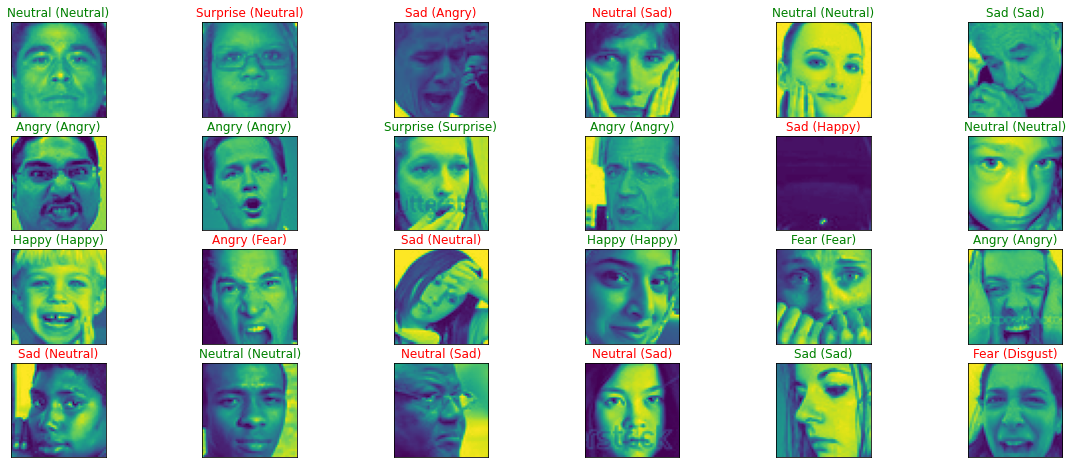

In [21]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = label_dict[(np.argmax(predict[index]))]
    true_index = label_dict[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))